In [2]:
#%%
from collections import defaultdict
import pandas as pd
from Bio import SeqIO
from Bio import pairwise2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import matplotlib
# matplotlib font parameters
font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

#%%


In [3]:

def get_appris_status(tag):
    tag = tag.strip('\n')
    items = tag.split(',')
    for item in items:
        if 'appris' in item:
            return item
    return 'not_appris'
def get_internal_category(row):
    if row['gencode_internal']:
        return 'GENCODE internal to CPAT'
    if row['cpat_internal']:
        return 'CPAT internal to GENCODE'
    return 'Not internal'

comparison = pd.read_table('./GENCODE.CPAT.comparison_with_meta.tsv')
comparison['GENCODE_BASIC'] = ~comparison['transcript_id'].isna()
protein_coding = comparison[comparison['gene_type'] == 'protein_coding'].copy()
protein_coding['selenocystine'] = protein_coding['tag'].apply(lambda tag: 'seleno' in tag)

protein_coding['appris'] = protein_coding['tag'].apply(lambda tag: 'appris' in tag)
protein_coding['appris_status'] = protein_coding['tag'].apply(get_appris_status)

pc_no_match = protein_coding[~protein_coding['Match']].copy()

pc_no_match['gencode_internal'] = pc_no_match.apply(lambda row: row['Ref-Seq'] in row['CPAT-Seq'], axis=1)
pc_no_match['cpat_internal'] = pc_no_match.apply(lambda row: row['CPAT-Seq'] in row['Ref-Seq'], axis=1)
pc_no_match['internal'] = pc_no_match['gencode_internal'] | pc_no_match['cpat_internal']
pc_no_match['internal_category'] = pc_no_match.apply(get_internal_category, axis=1)

pc_no_match['score'] = pc_no_match.apply(lambda row: pairwise2.align.globalxx(row['Ref-Seq'], row['CPAT-Seq'], score_only=True), axis=1)
pc_no_match['normalized_score'] = pc_no_match.apply(lambda row: row['score'] / max(len(row['CPAT-Seq']), len(row['Ref-Seq'])), axis = 1)


comparison.to_csv('./GENCODE.CPAT.comparison_with_meta.tsv', index=False, sep='\t')
protein_coding.to_csv('./GENCODE.CPAT.comparison_with_meta.protein_coding.tsv',index=False, sep='\t')
pc_no_match.to_csv('./GENCODE.CPAT.comparison_with_meta.protein_coding.cpat_gencode_not_identical.tsv',index=False, sep='\t')

pc_diff_start = pc_no_match[~pc_no_match['first_25_match']]
diff_start_same_stop = pc_diff_start[pc_diff_start['last_25_match']]


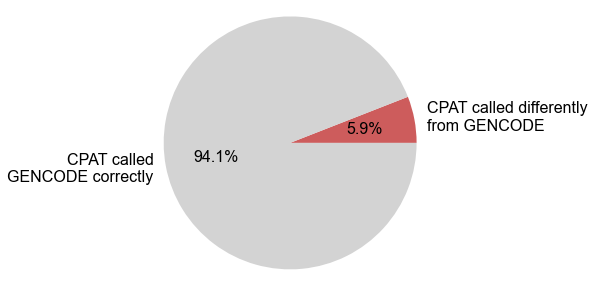

In [138]:



labels = [
    'CPAT called differently\nfrom GENCODE',
    'CPAT called\nGENCODE correctly', 
    
]
colors = ['indianred', 'lightgrey']
fig, ax = plt.subplots(figsize=(5,5))
protein_coding.groupby('Match').size().plot.pie(ax =ax, labels=labels, autopct='%.1f%%', colors=colors)
ax.set_ylabel('')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('./plots/pie_gencode_cpat_call_compare.svg', bbox_inches='tight')

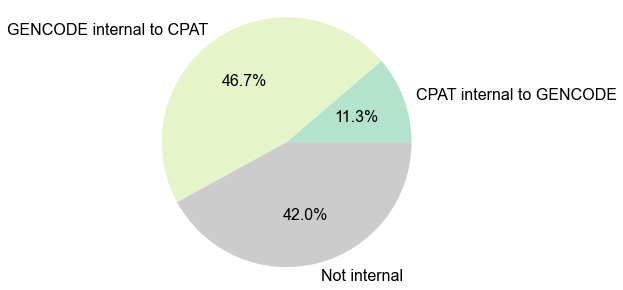

In [4]:
# labels = [
#     'CPAT internal to GENCODE',
#     'GENCODE internal to CPAT',
#     'Not internal' 
# ]
colors = ['#6a4c93',]
fig, ax = plt.subplots(figsize=(5,5))
pc_no_match.groupby('internal_category').size().plot.pie(ax =ax, autopct='%.1f%%', cmap='Pastel2')
ax.set_ylabel('')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('./plots/pie_different_internal.svg', bbox_inches='tight')

In [ ]:

fig, ax = plt.subplots()
sns.histplot(hue='last_25_match', x='normalized_score', data=pc_no_match, bins=50, ax=ax)
ax.set_ylabel('Number of isoforms')
ax.set_xlabel('Normallized alignment score')


In [8]:



print(
pc_no_match[pc_no_match['first_25_match']].groupby('selenocystine').size()
)
print(
    pc_no_match.groupby('gencode_internal').size()
)

# %%
print(pc_no_match.groupby('cpat_internal').size())

print(pc_no_match.groupby(['gencode_internal', 'cpat_internal']).size())
# %%


selenocystine
False    26
True     34
dtype: int64
gencode_internal
False    1853
True     1624
dtype: int64
cpat_internal
False    3085
True      392
dtype: int64
gencode_internal  cpat_internal
False             False            1461
                  True              392
True              False            1624
dtype: int64


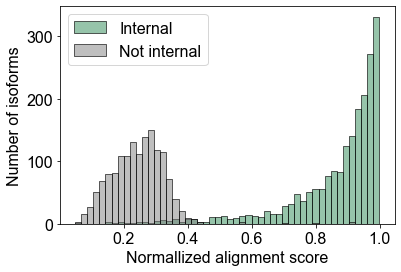

In [5]:

fig, ax = plt.subplots()
sns.histplot(hue='internal', x='normalized_score', data=pc_no_match, bins=50, ax=ax, palette=['grey', 'seagreen'])
ax.set_ylabel('Number of isoforms')
ax.set_xlabel('Normallized alignment score')
ax.legend(['Internal', 'Not internal'])
plt.savefig('plots/histplot_internal_not_internal.svg', bbox_inches='tight')
# %%


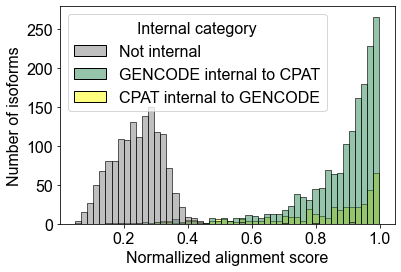

In [7]:

fig, ax = plt.subplots()
sns.histplot(
    hue='internal_category', 
    x='normalized_score', 
    data=pc_no_match, bins=50, ax=ax, 
    palette=['grey', 'seagreen', 'yellow'])
ax.set_ylabel('Number of isoforms')
ax.set_xlabel('Normallized alignment score')
# ax.legend([ 'GENCODE internal to CPAT', 'CPAT internal to GENCODE', 'Not internal',])
ax.get_legend().set_title('Internal category')
# ax.get_legend().set_labels()
# %%



In [7]:

pc_not_internal = pc_no_match[(~pc_no_match['gencode_internal']) & (~pc_no_match['cpat_internal'])]


# %%
pc_not_internal.groupby('appris').size()
# %%
gencode_all_cpat_orfs = defaultdict(list)
for record in SeqIO.parse('./GENCODE.ORF_seqs.fa', 'fasta'):
    transcript = record.id.split('|')[0]
    gencode_all_cpat_orfs[transcript].append(str(record.seq))

# %%
def is_gencode_found_in_any_cpat_orfs(row, gencode_all_cpat_orfs):
    gencode_sequence = row['Ref-Seq']
    orf_sequences = gencode_all_cpat_orfs[row['Transcript']]
    for orf_seq in orf_sequences:
        if gencode_sequence == orf_seq:
            return 'match'
        elif gencode_sequence in orf_seq
            return 'gencode_internal'
        elif orf_seq in gencode_sequence:
            return 'cpat_internal'
    return 'not found'

pc_not_internal['is_gencode_found_in_any_cpat_orfs'] = pc_not_internal.apply(lambda row: is_gencode_found_in_any_cpat_orfs(row, gencode_all_cpat_orfs), axis=1)
pc_not_internal.groupby('is_gencode_found_in_any_cpat_orfs').size()
# %%
pc_not_internal.groupby(['first_25_match', 'last_25_match']).size()


# %%
pc_not_internal.groupby('appris').size()


<ipython-input-7-6db9e35c556e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pc_not_internal['is_gencode_found_in_any_cpat_orfs'] = pc_not_internal.apply(lambda row: is_gencode_found_in_any_cpat_orfs(row, gencode_all_cpat_orfs), axis=1)


appris
False    1038
True      423
dtype: int64

In [10]:
def get_ends_category(row):
    n=25
    if row[f'first_{n}_match'] and not row[f'last_{n}_match']:
        return 'Different C-terminus'
    elif not row[f'first_{n}_match'] and row[f'last_{n}_match']:
        return 'Different N-terminus'
    else:
        return 'Different N and C-terminus'
pc_no_match['ends_category'] = pc_no_match.apply(get_ends_category, axis=1)

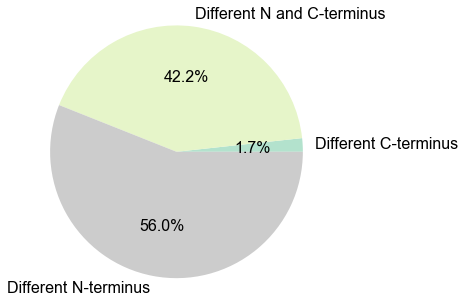

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
pc_no_match.groupby('ends_category').size().plot.pie(autopct='%.1f%%', cmap='Pastel2')
ax.set_ylabel('')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('./plots/pie_different_nterm_cterm.svg', bbox_inches='tight')


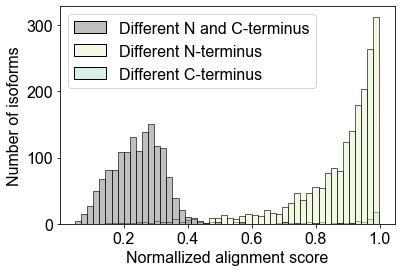

In [22]:
from matplotlib.colors import Colormap

fig, ax = plt.subplots()
sns.histplot(
    hue='ends_category', x='normalized_score', 
    data=pc_no_match, bins=50, ax=ax, 
    palette=['grey', '#e6f5c9ff', '#b3e2cdff'])
ax.set_ylabel('Number of isoforms')
ax.set_xlabel('Normallized alignment score')
ax.get_legend().set_title('')
plt.savefig('plots/histplot_N_C_terminus.svg', bbox_inches='tight')
# %%

In [19]:

a = plt.get_cmap('Pastel2')
print(a)